In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [2]:
stock_prices = pd.read_csv('stock_prices.csv', parse_dates=True, index_col='Date')
day_1_returns = pd.read_csv('1_day_returns.csv', parse_dates=True, index_col='Date')
day_10_returns = pd.read_csv('10_days_returns.csv', parse_dates=True, index_col='Date')
daily_log_returns = pd.read_csv('log_returns.csv', parse_dates=True, index_col='Date')

rates = pd.read_csv('rates_interpolated.csv', parse_dates=True, index_col='Date')
rates.columns = rates.columns.astype(float)

# 1. Данные

In [3]:
day_10_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-14,-0.046112,0.033590,-0.033061,0.002551,-0.035911,-0.063063,-0.055305,-0.064180
2009-07-15,0.042874,0.084083,0.017569,0.061363,0.042934,0.011609,0.003324,0.034152
2009-07-16,0.026554,0.059934,0.025769,0.054224,0.036310,-0.016630,0.019411,0.026900
2009-07-17,0.109610,0.069516,0.059996,0.076118,0.021175,0.019244,0.049897,0.142706
2009-07-20,0.099232,0.057434,0.075673,0.111995,0.091039,0.085354,0.064516,0.163021


In [4]:
daily_log_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-02,-0.059875,-0.004317,-0.018642,-0.018222,-0.035043,-0.038942,-0.033347,-0.058686
2009-07-03,-0.007269,0.027306,-0.003541,0.017240,0.023980,0.023082,-0.006671,-0.004432
2009-07-06,-0.050879,-0.014413,-0.026536,-0.005022,-0.020954,-0.029037,-0.020968,-0.072136
2009-07-07,-0.000614,0.011040,0.002354,-0.007432,-0.001501,-0.009601,-0.004110,0.018397
2009-07-08,-0.040118,-0.030875,-0.006003,-0.019484,-0.035316,-0.045646,-0.008270,-0.012843


In [5]:
rates.head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,13.5,14.0,14.5,15.0,15.5,16.0,16.5,17.0,17.5,18.0
Date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,9.18,10.56,11.135,11.71,11.815,11.92,11.8825,11.845,11.8075,11.77,...,11.623,11.622,11.621,11.62,11.62,11.62,11.62,11.62,11.62,11.62
2009-07-02,8.93,10.29,10.920,11.55,11.730,11.91,11.9075,11.905,11.9025,11.90,...,11.455,11.440,11.425,11.41,11.41,11.41,11.41,11.41,11.41,11.41
2009-07-03,8.91,10.33,11.005,11.68,11.845,12.01,11.9725,11.935,11.8975,11.86,...,11.411,11.404,11.397,11.39,11.39,11.39,11.39,11.39,11.39,11.39
2009-07-06,8.84,10.20,10.925,11.65,11.900,12.15,12.1725,12.195,12.2175,12.24,...,11.757,11.738,11.719,11.70,11.70,11.70,11.70,11.70,11.70,11.70
2009-07-07,9.09,10.45,11.035,11.62,11.765,11.91,11.8975,11.885,11.8725,11.86,...,11.614,11.606,11.598,11.59,11.59,11.59,11.59,11.59,11.59,11.59


# 2. Описание данных

- Цены закрытия акций выружены с Yahoo Finance.
- Ставки взяты с сайта ЦБ РФ.
- Кросс-валютный курс выгружен с сайта stooq.com, который берет информацию с Google Finance.

Выведим описательные статистики, skew, kurtosis и автокорреляцию по первому лагу арифметических 10-дневных доходностей акций.

In [6]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [7]:
def describe(df):
    """
    Print description of datafame with autocorrelation, skew and kurtosis
    """
    description = df.describe()
    
    colnames = list(df.columns)
    autocorrelation = []
    
    for colname in colnames:
        autocorrelation.append(df[colname].autocorr(lag = 1))
        
    autocorr = pd.DataFrame([autocorrelation], columns = colnames, index=['autocorr'])
    skews = pd.DataFrame([skew(df, axis = 0).tolist()], columns = colnames, index=['skew'])
    kurt = pd.DataFrame([kurtosis(df, axis = 0).tolist()], columns = colnames, index=['kurtosis'])
    
    description = description.append(autocorr)
    description = description.append(skews)
    description = description.append(kurt)
    
    return description

In [8]:
describe(daily_log_returns)

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.000173,-0.000764,-0.000198,0.000128,-0.000502,-0.000800,0.000427,0.000444
std,0.023887,0.030933,0.018482,0.016300,0.035221,0.033601,0.013476,0.024755
min,-0.076172,-0.168794,-0.140368,-0.061640,-0.283638,-0.195471,-0.053226,-0.114285
25%,-0.014169,-0.017052,-0.009557,-0.008810,-0.018900,-0.018744,-0.007538,-0.013972
50%,0.001184,-0.001252,-0.000051,-0.000159,-0.000306,-0.001931,0.000693,0.000828
75%,0.014911,0.016339,0.009352,0.009139,0.018373,0.018677,0.008970,0.015609
max,0.095437,0.161956,0.089487,0.064578,0.204678,0.120018,0.038298,0.076540
autocorr,0.003796,0.014173,0.030910,-0.026055,-0.023473,0.042604,0.056323,0.049168
skew,-0.111088,-0.028955,-0.561599,0.027504,-0.538963,-0.231325,-0.205137,-0.140894


# 3. VaR и ES для акций

## Дельта-нормальный метод

Функция использует следующие формулы для подсчета VaR и ES:

$$
VaR_{\alpha}(X) = - \mu_p + \sigma_p \cdot \Phi^{-1}(\alpha)
$$

$$
ES_{\alpha}(X) = - \mu_p + \sigma_p \cdot \frac{\phi(\Phi^{-1}(\alpha))}{\alpha}
$$

In [9]:
import scipy.stats as st

In [10]:
def delta_norm_stock_VaR_ES(start, end, p_weights, alpha, return_period, daily_log_returns = daily_log_returns):
    cov = np.array(daily_log_returns[start:end].cov())
    stdev_p = np.sqrt(p_weights@cov@p_weights)
    mu_p = (daily_log_returns@p_weights.T).mean()
    
    VaR = - mu_p + stdev_p * st.norm.ppf(1 - alpha) * np.sqrt(return_period)
    ES = - mu_p + stdev_p * st.norm.pdf(st.norm.ppf(1 - alpha))/alpha * np.sqrt(return_period)
    # check how return peroid is included in ES

    return VaR, ES

In [11]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
future_log_returns = daily_log_returns[daily_log_returns.index[-1] - dt.timedelta(days = 364):]@p_weights.T

In [26]:
return_period = 10
alpha = 0.01

VaR_delta_norm_forecast = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 728), 
                               p_weights, alpha, return_period = 1)[0] for i in range(future_log_returns.shape[0])];
ES_delta_norm_forecast = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 728), 
                               p_weights, alpha, return_period = 1)[1] for i in range(future_log_returns.shape[0])];

VaR_delta_norm_forecast = pd.Series(VaR_delta_norm_forecast, pd.to_datetime(future_log_returns.index))
ES_delta_norm_forecast = pd.Series(ES_delta_norm_forecast, pd.to_datetime(future_log_returns.index))

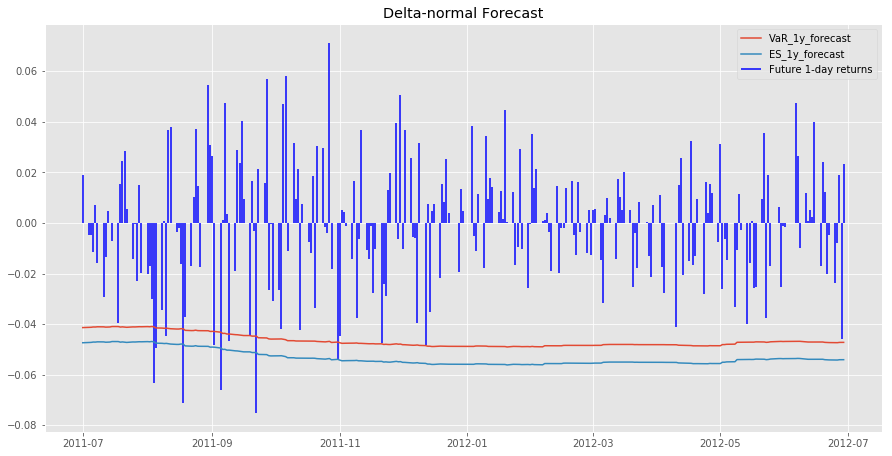

In [27]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_delta_norm_forecast)
plt.plot(ES_delta_norm_forecast)
plt.vlines(future_log_returns.index, ymax=list(future_log_returns), ymin = 0, colors='b')
plt.legend(['VaR_1y_forecast', 'ES_1y_forecast', 'Future 1-day returns'])
plt.title('Delta-normal Forecast');

## Historical simulation

VaR и ES для Historical simulation считались так:

$$
VaR_\alpha(X) = - inf{[x|P(X \leq x) > \alpha]}
$$

$$
ES_\alpha(X) = \frac{\Sigma [x|P(X \leq x) > \alpha]}{\#x}
$$

In [14]:
def historical_stock_VaR_ES(start, end, p_weights, alpha, returns, plot=False):
    
    #Calculation
    p_returns = returns[start:end]@p_weights.T
    p_returns = p_returns.sort_values()
    
    VaR_location = int(np.floor(p_returns.shape[0] * alpha))
    VaR = - p_returns[VaR_location]
    ES = - p_returns[:VaR_location].mean()
    
    #Plot    
    if plot == True:
        plt.figure(figsize=(15,7.5))
        plt.tick_params(labelsize=14)
        plt.title('Historical Simulation')
        plt.legend(['Empirical PMF', 'VaR', 'ES'])  
        
        plt.scatter(p_returns, np.linspace(0, 1, p_returns.shape[0]), s = 20)
        plt.scatter(p_returns[VaR_location], np.linspace(0, 1, p_returns.shape[0])[VaR_location], s = 300)
        plt.scatter(p_returns[:VaR_location].mean(), np.linspace(0, 1, p_returns.shape[0])[:VaR_location].mean(), s = 300)
        plt.xlabel('P\L')
        plt.legend(['Empirical PMF', 'VaR', 'ES'])
    
    return VaR, ES

In [21]:
future_stock_10_day_returns = day_10_returns[day_10_returns.index[-1] - dt.timedelta(days = 364):]@p_weights.T

In [47]:
alpha = 0.01

VaR_historical_forecast = [ -historical_stock_VaR_ES(day_10_returns.index[i], 
                                                        day_10_returns.index[i] + dt.timedelta(days = 716), 
                               p_weights, alpha, returns = day_10_returns)[0] 
                           for i in range(future_stock_10_day_returns.shape[0])]
ES_historical_forecast = [ -historical_stock_VaR_ES(day_10_returns.index[i], 
                                                        day_10_returns.index[i] + dt.timedelta(days = 716), 
                               p_weights, alpha, returns = day_10_returns)[1] 
                          for i in range(future_stock_10_day_returns.shape[0])]

VaR_historical_forecast = pd.Series(VaR_historical_forecast, pd.to_datetime(future_stock_10_day_returns.index))
ES_historical_forecast = pd.Series(ES_historical_forecast, pd.to_datetime(future_stock_10_day_returns.index))

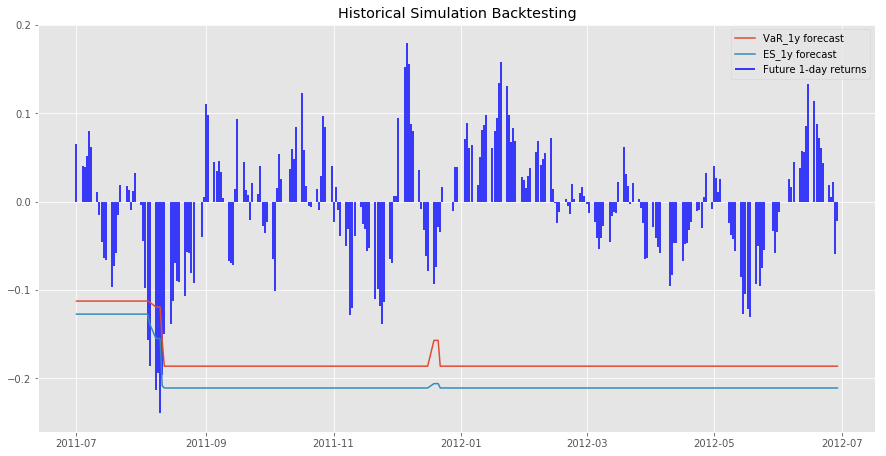

In [49]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_historical_forecast)
plt.plot(ES_historical_forecast)
plt.vlines(future_stock_10_day_returns.index, ymax=list(future_stock_10_day_returns), ymin = 0, colors='b')
plt.legend(['VaR_1y forecast', 'ES_1y forecast', 'Future 1-day returns'])
plt.title('Historical Simulation Backtesting');

VaR: C вероятностью 0.99 портфель не потеряет за 10-дневный срок больше чем 11.24% стоимости
ES: Если портфель за 10 дней будет терять больше, чем 11.24% стоимости, то он в среднем потеряет 12.72%


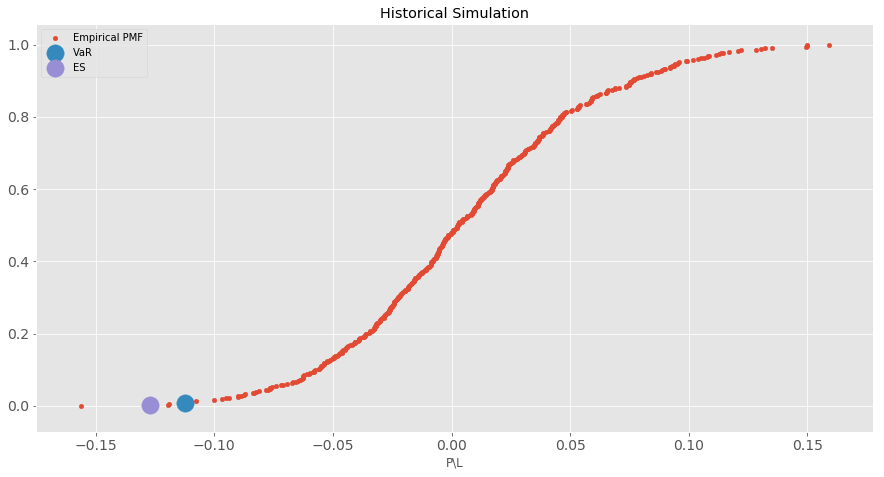

In [56]:
VaR_hist, ES_hist = historical_stock_VaR_ES(day_10_returns.index[0], 
                                            day_10_returns.index[0] + dt.timedelta(716),
                                            p_weights, alpha, plot = True, returns = day_10_returns)

print(f'VaR: C вероятностью {1-alpha} портфель не потеряет за 10-дневный срок больше чем {round(VaR_hist * 100, 2)}% стоимости')
print(f'ES: Если портфель за 10 дней будет терять больше, чем {round(VaR_hist * 100, 2)}% стоимости, то он в среднем потеряет {round(ES_hist*100, 2)}%')

# 4. VaR и ES для облигаций

Найдем структуру купонных платежей.

In [13]:
class bond():
    """
    Class Bond is used to get structure of payments of bonds with given parameter.
    Bond can be defined in two ways:
        1. Coupon, frequency, maturity, amortization.
        2. Dates and payments.
    
    Properties are:
        .dates - dates as np.array
        .payments - payments as np.array
        .structure - dict of dates as keys ans payments as items     
    """
    def __init__(s, coupon = False, frequency = False, maturity = False, amortization = False, 
                 dates = None, payments = None):

        if dates is not None and payments is not None:
            s.dates = dates
            s.payments = payments           
        else:           
            dates = np.linspace(0, maturity, frequency * maturity + 1)[1:]
            s.dates = dates
            
            if amortization == True:
                amortization = np.ones(maturity*frequency) * (100/(maturity*frequency))
                s.amortization = amortization
                payments = np.linspace(1, 0, maturity*frequency + 1)[:-1] * coupon/frequency + amortization
                s.payments = payments
            else:
                principal = np.zeros(maturity*frequency)
                principal[-1] = 100
                payments = np.ones(frequency * maturity) * coupon/frequency + principal
                s.payments = payments
        
        s.structure = {date: payment for (date, payment) in zip(dates, payments)}

In [14]:
def bond_portfolio(*bonds):     
    """
    A function to get the structure of payments of a portfolio of bonds from a number of bonds.
    Output is a class bond object.
    """
    portfolio = bonds[0].structure
    
    for Bond in bonds[1:]:
        Bond = Bond.structure
        portfolio = {k: portfolio.get(k, 0) + Bond.get(k, 0) for k in set(portfolio) | set(Bond)}   
        
    dates = np.array(list(rates.columns))
    portfolio = {k: portfolio.get(k, 0) + 0 for k in set(portfolio) | set(dates)}
    portfolio = {k: portfolio.get(k, 0) for k in sorted(portfolio)}
    
    payments = np.array(list(portfolio.values()))
    structured_portfolio = bond(dates = dates, payments = payments)
    
    return structured_portfolio

def dcf(bond_portfolio, rates):
    """
    Get DCF of a bond portfolio.
    Input: bond_portfolio as bond class object
           rates as a dataframe of rates on a required period
    Output: Dataframe of DCF
    
    """
    
    dcf = np.ones([rates.shape[0], rates.shape[1]]) * portfolio.payments    
    dcf = dcf * np.exp(-rates/100 * np.array(list(rates.columns)))
    
    return dcf

def duration(bond_portfolio, rates):
    """
    Get duration of a bond portfolio.
    Input: bond_portfolio as bond class object
           rates as a dataframe of rates on a required period
    Output: Series of duration
    
    """
    DCF = dcf(bond_portfolio, rates)
    dates = np.ones([DCF.shape[0], DCF.shape[1]]) * np.array(list(rates.columns))    
    return (DCF * dates).sum(axis = 1) / DCF.sum(axis = 1)

In [15]:
bond1 = bond(coupon = 4.84, frequency = 2, maturity = 2)
bond2 = bond(coupon = 6.14, frequency = 2, maturity = 3)
bond3 = bond(coupon = 5.7, frequency = 2, maturity = 6)
bond4 = bond(coupon = 4.34, frequency = 2, maturity = 10, amortization = True)
bond5 = bond(coupon = 2.28, frequency = 1, maturity = 13, amortization = True)
bond6 = bond(coupon = 4.73, frequency = 1, maturity = 18, amortization = True)

portfolio = bond_portfolio(bond1, bond2, bond3, bond4, bond5, bond6)

In [16]:
DCF = dcf(portfolio, rates)

In [17]:
duration(portfolio, rates).head()

Date
2009-07-01    3.947785
2009-07-02    3.950506
2009-07-03    3.960187
2009-07-06    3.919638
2009-07-07    3.942217
dtype: float64

## Дельта-нормальный метод

## PCA

# 5. Учет валютного риска

# 6. Backtesting

## Подпортфель акций

Найдем доходности портфеля, на которых будем проводить бэктестинг.

In [59]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
historic_stock_log_returns = (daily_log_returns@p_weights.T)[daily_log_returns.index[252]:daily_log_returns.index[504]]

### Дельта-нормальный метод

In [62]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
return_period = 10
alpha = 0.01

VaR_delta_norm_backtesting = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, return_period = 1)[0] for i in range(historic_stock_log_returns.shape[0])]
ES_delta_norm_backtesting = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], 
                                                        daily_log_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, return_period = 1)[1] for i in range(historic_stock_log_returns.shape[0])];

VaR_delta_norm_backtesting = pd.Series(VaR_delta_norm_backtesting, pd.to_datetime(historic_stock_log_returns.index))
ES_delta_norm_backtesting = pd.Series(ES_delta_norm_backtesting, pd.to_datetime(historic_stock_log_returns.index))

Количество пробитий: 0


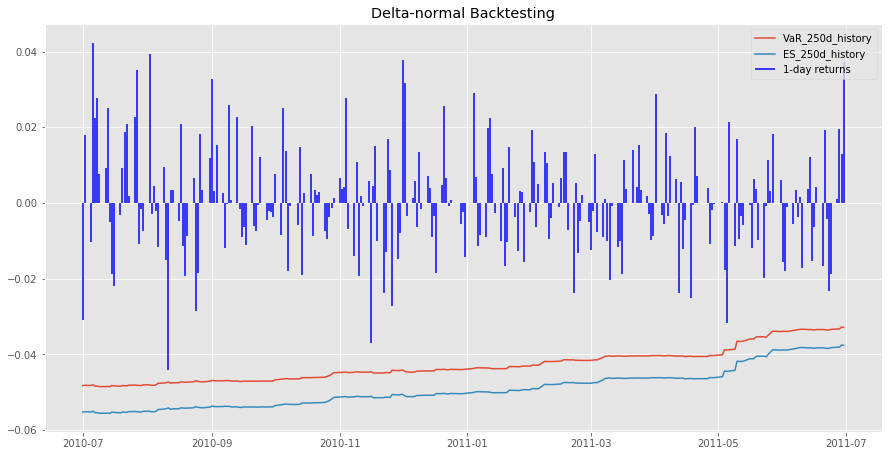

In [66]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_delta_norm_backtesting);
plt.plot(ES_delta_norm_backtesting);
plt.vlines(historic_stock_log_returns.index, ymax=list(historic_stock_log_returns), ymin = 0, colors='b')
plt.legend(['VaR_250d_history', 'ES_250d_history', '1-day returns'])
plt.title('Delta-normal Backtesting');
print("Количество пробитий:", (historic_stock_log_returns < VaR_delta_norm_backtesting).sum())

### Historical simulation

In [16]:
historics_stock_1_day_returns = (day_1_returns@p_weights.T)[day_1_returns.index[252]:day_1_returns.index[504]]

In [17]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
alpha = 0.01

VaR_historical_backtesting = [ -historical_stock_VaR_ES(day_1_returns.index[i], 
                                                        day_1_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, returns = day_1_returns)[0] for i in range(historics_stock_1_day_returns.shape[0])]
ES_historical_backtesting = [ -historical_stock_VaR_ES(day_1_returns.index[i], 
                                                        day_1_returns.index[i] + dt.timedelta(days = 363), 
                               p_weights, alpha, returns = day_1_returns)[1] for i in range(historics_stock_1_day_returns.shape[0])]

VaR_historical_backtesting = pd.Series(VaR_historical_backtesting, pd.to_datetime(historics_stock_1_day_returns.index))
ES_historical_backtesting = pd.Series(ES_historical_backtesting, pd.to_datetime(historics_stock_1_day_returns.index))

Количество пробитий: 0


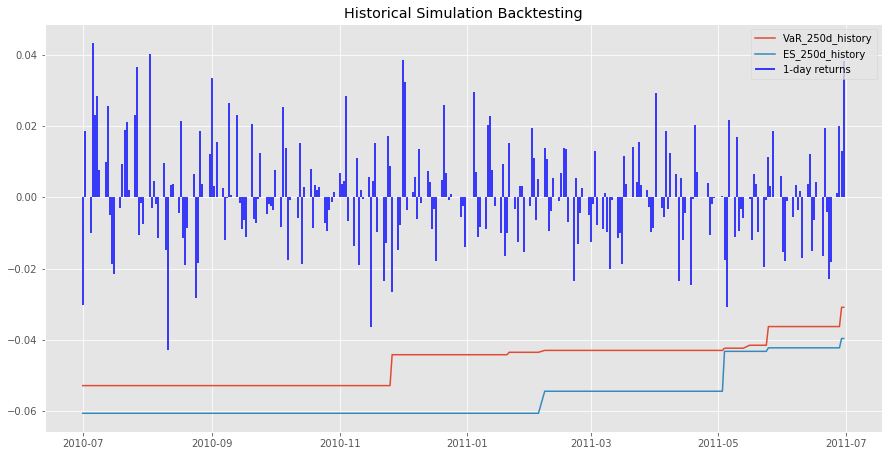

In [67]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_historical_backtesting)
plt.plot(ES_historical_backtesting)
plt.vlines(historics_stock_1_day_returns.index, ymax=list(historics_stock_1_day_returns), ymin = 0, colors='b')
plt.legend(['VaR_250d_history', 'ES_250d_history', '1-day returns'])
plt.title('Historical Simulation Backtesting');
print("Количество пробитий:", (historics_stock_1_day_returns < VaR_historical_backtesting).sum())

## Подпортфель облигаций

## 7. Задача c лимитом

Задача не еще решена.

Ниже просто пример нахождения оптимальных весов в портфеле акций.

In [17]:
from scipy.optimize import minimize

In [18]:
w = p_weights

In [24]:
def loss(w, returns = daily_log_returns):
    cov = np.array(returns.cov())
    return w@cov@w

cons = ({'type': 'eq', 'fun' : lambda w: np.sum(w) - 1.0},
        {'type': 'ineq', 'fun' : lambda w: w[0]},
        {'type': 'ineq', 'fun' : lambda w: w[1]},
        {'type': 'ineq', 'fun' : lambda w: w[2]},
        {'type': 'ineq', 'fun' : lambda w: w[3]},
        {'type': 'ineq', 'fun' : lambda w: w[4]},
        {'type': 'ineq', 'fun' : lambda w: w[5]},
        {'type': 'ineq', 'fun' : lambda w: w[6]},
        {'type': 'ineq', 'fun' : lambda w: w[7]})

w0 = np.random.rand(w.shape[0])
res = minimize(loss, w0, method='BFGS', constraints=cons,
               bounds=[(0, np.inf) for i in range(w.shape[0])], options={'disp': True},)

print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 46
         Function evaluations: 540
         Gradient evaluations: 54
[-0.03062127  0.0200756  -0.00374186 -0.04916151 -0.00243804 -0.00052408
  0.03078691  0.02613867]
